In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
from torchvision.utils import save_image, make_grid
from vit import *

In [2]:
# Setup: folders and models
# model_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/model_save/"
model_folder =  "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/model_save/"
model_file = "vit_model_0404.pt"
model_path = model_folder + model_file

# database_folder = "/usr/itetnas04/data-scratch-01/ddordevic/data/cluster_scripts/vit_copy/extracted_features/"
database_folder = "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/extracted_features/"

database_file_train = "training_mnist.pkl" # or "test_mnist.pkl"
database_file_test = "test_mnist.pkl"

database_path_train = database_folder + database_file_train
database_path_test = database_folder + database_file_test

K = 3 # return K best matching images

In [3]:
# Load the database into a pandas DataFrame
# DataFrame contains the following columns: ['image','feature','label']
# The 1st columns contains a flattened image
# The training database will be used for matrix building, while the tet database will be used to fetch query images

database_train_df = pd.read_pickle(database_path_train)
database_test_df = pd.read_pickle(database_path_test)

In [4]:
# Get database length
num_images_train = len(database_train_df)
num_images_test = len(database_test_df)

In [5]:
# Fetch the train database matrix
database_matrix = []
for i in range(num_images_train):
    database_matrix.append(database_train_df.iloc[i]['feature'])
database_matrix = torch.stack(database_matrix)

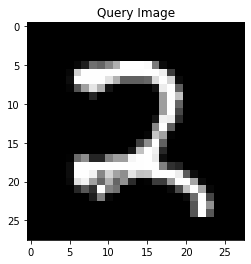

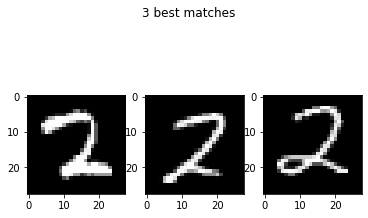

In [10]:
# Extract a random query image from the database
query_img_idx = np.random.randint(0, num_images_test)
query_img = database_test_df.iloc[query_img_idx]['image']#.unflatten(0, unflatten_shape)
query_ftrs = database_test_df.iloc[query_img_idx]['feature']
query_label = database_test_df.iloc[query_img_idx]['label']

# Multiply the database matrix and the query feature vector
match_scores = database_matrix @ query_ftrs
sorted_scores, sorted_ind = torch.sort(match_scores, descending=True)

# Take K best matches
k_best_ind = sorted_ind[0:K]

# Visualize the K best images
# Print the query image:
plt.imshow(query_img[0], cmap='gray')
plt.title('Query Image')

# Print the best matching images (according to inner product, as suggested in the paper I found)
fig, axs = plt.subplots(1, K)
fig.suptitle(f'{K} best matches')

for i, best_idx in enumerate(k_best_ind.numpy()):
    axs[i].imshow(database_train_df.iloc[best_idx]['image'][0], cmap='gray')

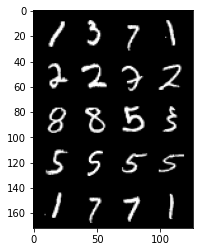

In [14]:
# Testing of the system on 5 random queries, with top-3 results taken into consideration
num_runs = 5

img_save_folder = "C:/Users/danil/Desktop/Master thesis/Code/msc-thesis/test_outputs/"
img_name = "vit_mnist_grid_"

big_grid = []

for i in range(num_runs):
    # Extract a random query image from the database
    query_img_idx = np.random.randint(0, num_images_test)
    query_img = database_test_df.iloc[query_img_idx]['image']#.unflatten(0, unflatten_shape)
    query_ftrs = database_test_df.iloc[query_img_idx]['feature']
    query_label = database_test_df.iloc[query_img_idx]['label']

    # Multiply the database matrix and the query feature vector
    match_scores = database_matrix @ query_ftrs
    sorted_scores, sorted_ind = torch.sort(match_scores, descending=True)

    # Take K best matches
    k_best_ind = sorted_ind[0:K].numpy()

    # Grid
    grid_list = [query_img]

    for j in k_best_ind:
        grid_list.append(database_train_df.iloc[j]['image'])

    grid = make_grid(grid_list)
    big_grid.append(grid)

    # Save images to img_save_folder
    img_path = img_save_folder + img_name + str(i) + '.png'
    save_image(grid, img_path)

big_grid = make_grid(big_grid, nrow=1)
save_image(big_grid, img_save_folder + img_name + 'big.png')

plt.imshow(big_grid.permute(1,2,0))